In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score,make_scorer,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


## Load data


In [ ]:
# load pickled data
df_train = pd.read_pickle('df_train_final.pkl')
df_test= pd.read_pickle('df_test_final.pkl')

## Preprocess Data

In [ ]:
df_trans=df_test['TransactionID']
df_train.drop(columns=['uid','TransactionAmt','day','week','week2','month','ConfidenceInterval','TransactionID'],inplace=True)
df_test.drop(columns=['uid','TransactionAmt','day','week','week2','month','ConfidenceInterval','TransactionID'],inplace=True)


In [6]:
# we keep only common columns that are present in both train and test data
list1=df_test.columns
list2=df_train.columns
common_cols=list(set(list1).intersection(list2))

In [7]:
count=0
for i in list2:
    if i not in common_cols and i!='isFraud':
        df_train.drop(i,axis=1,inplace=True)
        count+=1
# remove columns in test data that are not in train data
for cols in df_test.columns:
    if cols not in df_train.columns:
        df_test.drop(cols,axis=1,inplace=True)
        count+=1
print(df_train.shape)
print(df_test.shape)
print('No of Dropped columns which are not common to both train and test',count)

(590540, 346)
(506691, 345)
No of Dropped columns which are not common to both train and test 0


## Train and Validation split

In [8]:
X=df_train.drop('isFraud', axis=1)
y=df_train['isFraud']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

## Naive bayes

In [10]:
model = GaussianNB()
model.fit(X_train, y_train)
y_tr=model.predict_proba(X_train)[:, 1]
fpr_nb_tr, tpr_nb_tr, threshold = metrics.roc_curve(y_train, y_tr)
y_pred=model.predict_proba(X_cv)[:, 1]
fpr_nb, tpr_nb, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_NB = metrics.auc(fpr_nb, tpr_nb)
roc_auc_NB_tr= metrics.auc(fpr_nb_tr, tpr_nb_tr)
print('Training_auc',roc_auc_NB_tr)
print('validation_auc',roc_auc_NB)

Training_auc 0.7061654293023369
validation_auc 0.7018230593147485


### Check for Overfitting

In [11]:
skf = StratifiedKFold(n_splits=4)
acc_train = []
acc_test = []
for train_index, test_index in skf.split(X,y):
   X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
   y_train1, y_test1 = y[train_index], y[test_index]
   model = GaussianNB()
   model.fit(X_train1, y_train1)
   y_train_pred = model.predict(X_train1)
   y_test_pred = model.predict(X_test1)
   acc_train.append(accuracy_score(y_train1, y_train_pred))
   acc_test.append(accuracy_score(y_test1, y_test_pred))

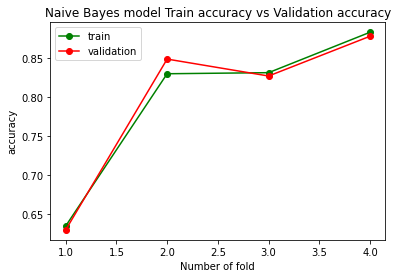

In [12]:
folds = range(1, skf.get_n_splits() + 1)
plt.title('Naive Bayes model Train accuracy vs Validation accuracy')
plt.plot(folds, acc_train, 'o-', color='green', label='train')
plt.plot(folds, acc_test, 'o-', color='red', label='validation')
plt.legend()
plt.xlabel('Number of fold')
plt.ylabel('accuracy')
plt.show()

## SVM

In [ ]:
model = SVC(probability=True)
model.fit(X_train, y_train)
y_tr=model.predict_proba(X_train)[:, 1]
fpr_svc_tr, tpr_svc_tr, threshold = metrics.roc_curve(y_train, y_tr)
y_pred=model.predict_proba(X_cv)[:, 1]
fpr_svc, tpr_svc, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_SVC = metrics.auc(fpr_svc, tpr_svc)
roc_auc_SVC_tr= metrics.auc(fpr_svc_tr, tpr_svc_tr)
print('Training_auc',roc_auc_SVC_tr)
print('validation_auc',roc_auc_SVC)

Training_auc 0.9705873637825214
validation_auc 0.8619228355545813


## Logistic Regression

In [13]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_tr=model.predict_proba(X_train)[:, 1]
fpr_lr_tr, tpr_lr_tr, threshold = metrics.roc_curve(y_train, y_tr)
y_pred=model.predict_proba(X_cv)[:, 1]
fpr_lr, tpr_lr, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_LR = metrics.auc(fpr_lr, tpr_lr)
roc_auc_LR_tr= metrics.auc(fpr_lr_tr, tpr_lr_tr)
print('Training_auc',roc_auc_LR_tr)
print('validation_auc',roc_auc_LR)

Training_auc 0.5366927265670655
validation_auc 0.5351898002206996


### Check for Overfitting

In [14]:
skf = StratifiedKFold(n_splits=4)
acc_train = []
acc_test = []
for train_index, test_index in skf.split(X,y):
   X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
   y_train1, y_test1 = y[train_index], y[test_index]
   model = LogisticRegression(random_state=0)
   model.fit(X_train1, y_train1)
   y_train_pred = model.predict(X_train1)
   y_test_pred = model.predict(X_test1)
   acc_train.append(accuracy_score(y_train1, y_train_pred))
   acc_test.append(accuracy_score(y_test1, y_test_pred))

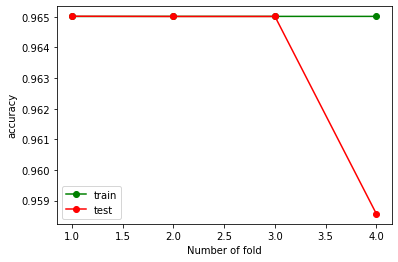

In [15]:
folds = range(1, skf.get_n_splits() + 1)
plt.plot(folds, acc_train, 'o-', color='green', label='train')
plt.plot(folds, acc_test, 'o-', color='red', label='test')
plt.legend()
plt.xlabel('Number of fold')
plt.ylabel('accuracy')
plt.show()

## Decision Tree

In [16]:
model = DecisionTreeClassifier(random_state=0, max_depth=20)
model.fit(X_train, y_train)
y=model.predict_proba(X_train)[:, 1]
fpr_dt_tr, tpr_dt_tr, threshold = metrics.roc_curve(y_train, y)
y_pred=model.predict_proba(X_cv)[:, 1]
fpr_dt, tpr_dt, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_DT = metrics.auc(fpr_dt, tpr_dt)
roc_auc_DT_tr= metrics.auc(fpr_dt_tr, tpr_dt_tr)
print('Training_auc',roc_auc_DT_tr)
print('validation_auc',roc_auc_DT)

Training_auc 0.9046295260215554
validation_auc 0.8210847396242313


## Checking for Overfitting

In [17]:
acc_train = []
acc_test = []
for i in range(5,31,1):
    model = DecisionTreeClassifier(random_state=0, max_depth=i)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_cv)
    acc_train.append(accuracy_score(y_train, y_train_pred))
    acc_test.append(accuracy_score(y_cv, y_test_pred))

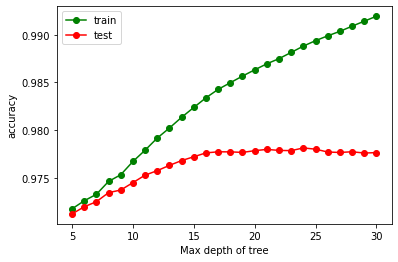

In [18]:
folds = range(5,31)
plt.plot(folds, acc_train, 'o-', color='green', label='train')
plt.plot(folds, acc_test, 'o-', color='red', label='test')
plt.legend()
plt.xlabel('Max depth of tree')
plt.ylabel('accuracy')
plt.show()

## Random Forest

In [19]:
parameters=[(20,20),(20,30),(20,40),(30,20),(30,30),(30,40)]
for i in parameters:
    model = RandomForestClassifier(n_estimators=i[0],max_depth=i[1])
    model.fit(X_train, y_train)
    y=model.predict_proba(X_train)[:, 1]
    fpr_rf_tr, tpr_rf_tr, threshold = metrics.roc_curve(y_train, y)
    y_pred = model.predict_proba(X_cv)[:, 1]
    fpr_rf, tpr_rf, threshold = metrics.roc_curve(y_cv, y_pred)
    roc_auc_RF = metrics.auc(fpr_rf, tpr_rf)
    roc_auc_RF_tr= metrics.auc(fpr_rf_tr, tpr_rf_tr)
    print('Training_auc',roc_auc_RF_tr)
    print('validation_auc',roc_auc_RF)

Training_auc 0.9740066560163276
validation_auc 0.9369120485932003
Training_auc 0.9988203979577506
validation_auc 0.9531038327766477
Training_auc 0.9999672788508245
validation_auc 0.9543028556444014
Training_auc 0.9790845183077753
validation_auc 0.9435376589961976
Training_auc 0.9990685330140356
validation_auc 0.9572092701141395
Training_auc 0.9999978637382129
validation_auc 0.9588903444774439


In [23]:
# Best model
model = RandomForestClassifier(n_estimators=30,max_depth=40)
model.fit(X_train, y_train)
y=model.predict_proba(X_train)[:, 1]
fpr_rf_tr, tpr_rf_tr, threshold = metrics.roc_curve(y_train, y)
y_pred = model.predict_proba(X_cv)[:, 1]
fpr_rf, tpr_rf, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_RF = metrics.auc(fpr_rf, tpr_rf)
roc_auc_RF_tr= metrics.auc(fpr_rf_tr, tpr_rf_tr)

## Checking for Overfitting

In [24]:
acc_train = []
acc_test = []
for i in range(20,45,5):
    for j in range(20,50,5):
        model = RandomForestClassifier(n_estimators=i,max_depth=j)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_cv)
        acc_train.append(accuracy_score(y_train, y_train_pred))
        acc_test.append(accuracy_score(y_cv, y_test_pred))

In [25]:
temp=[]
for i in range(20,65,5):
    for j in range(20,55,5):
        temp.append(str(i)+'_'+str(j))

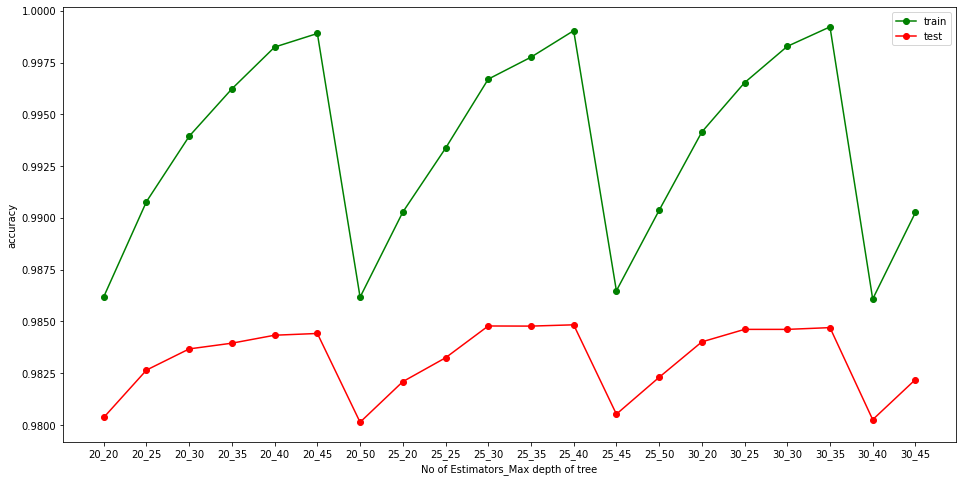

In [26]:
folds = temp[:20]
plt.figure(figsize=(16,8))
plt.plot(folds, acc_train[:20], 'o-', color='green', label='train')
plt.plot(folds, acc_test[:20], 'o-', color='red', label='test')
plt.legend()
plt.xlabel('No of Estimators_Max depth of tree')
plt.ylabel('accuracy')
plt.show()

## XG-boost

### Use GridSearchCV to find optimal XGboost parameters

In [ ]:
roc_auc_scorer = make_scorer(roc_auc_score, 
                             greater_is_better=True,
                             needs_threshold=True)

clf = xgb.XGBClassifier(nthread=-1, random_state=42,tree_method='gpu_hist')

param_grid = {
    'max_depth': [10, 12, 15],
    'min_samples_split': [3,5],
    'learning_rate': [0.02, 0.05], 
    'subsample': [0.8],
    'colsample_bytree': [0.4],
    'n_estimators': [1000,1500,2000], 
}

search = GridSearchCV(
    clf, 
    param_grid,  
    scoring=roc_auc_scorer,
).fit(X_train, y_train)

print(search.best_params_)


{'colsample_bytree': 0.4, 'learning_rate': 0.02, 'max_depth': 12, 'min_samples_split': 3, 'n_estimators': 2000, 'subsample': 0.8}


In [27]:
model_xgb_2000= xgb.XGBClassifier(colsample_bytree=0.4, max_depth=12, min_samples_split=3,learning_rate= 0.02,n_estimators=2000, subsample=0.8,n_jobs=-1)
model_xgb_2000.fit(X_train, y_train)
y_tr=model_xgb_2000.predict_proba(X_train)[:, 1]
fpr_xg_tr, tpr_xg_tr, threshold = metrics.roc_curve(y_train, y_tr)
y_pred = model_xgb_2000.predict_proba(X_cv)[:, 1]
fpr_xg, tpr_xg, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_xg = metrics.auc(fpr_xg, tpr_xg)
roc_auc_xg_tr= metrics.auc(fpr_xg_tr, tpr_xg_tr)
print('Training_auc',roc_auc_xg_tr)
print('validation_auc',roc_auc_xg)
y_pred_xgboost_2000=model_xgb_2000.predict_proba(df_test)[:, 1]

Training_auc 1.0
validation_auc 0.981320484732342


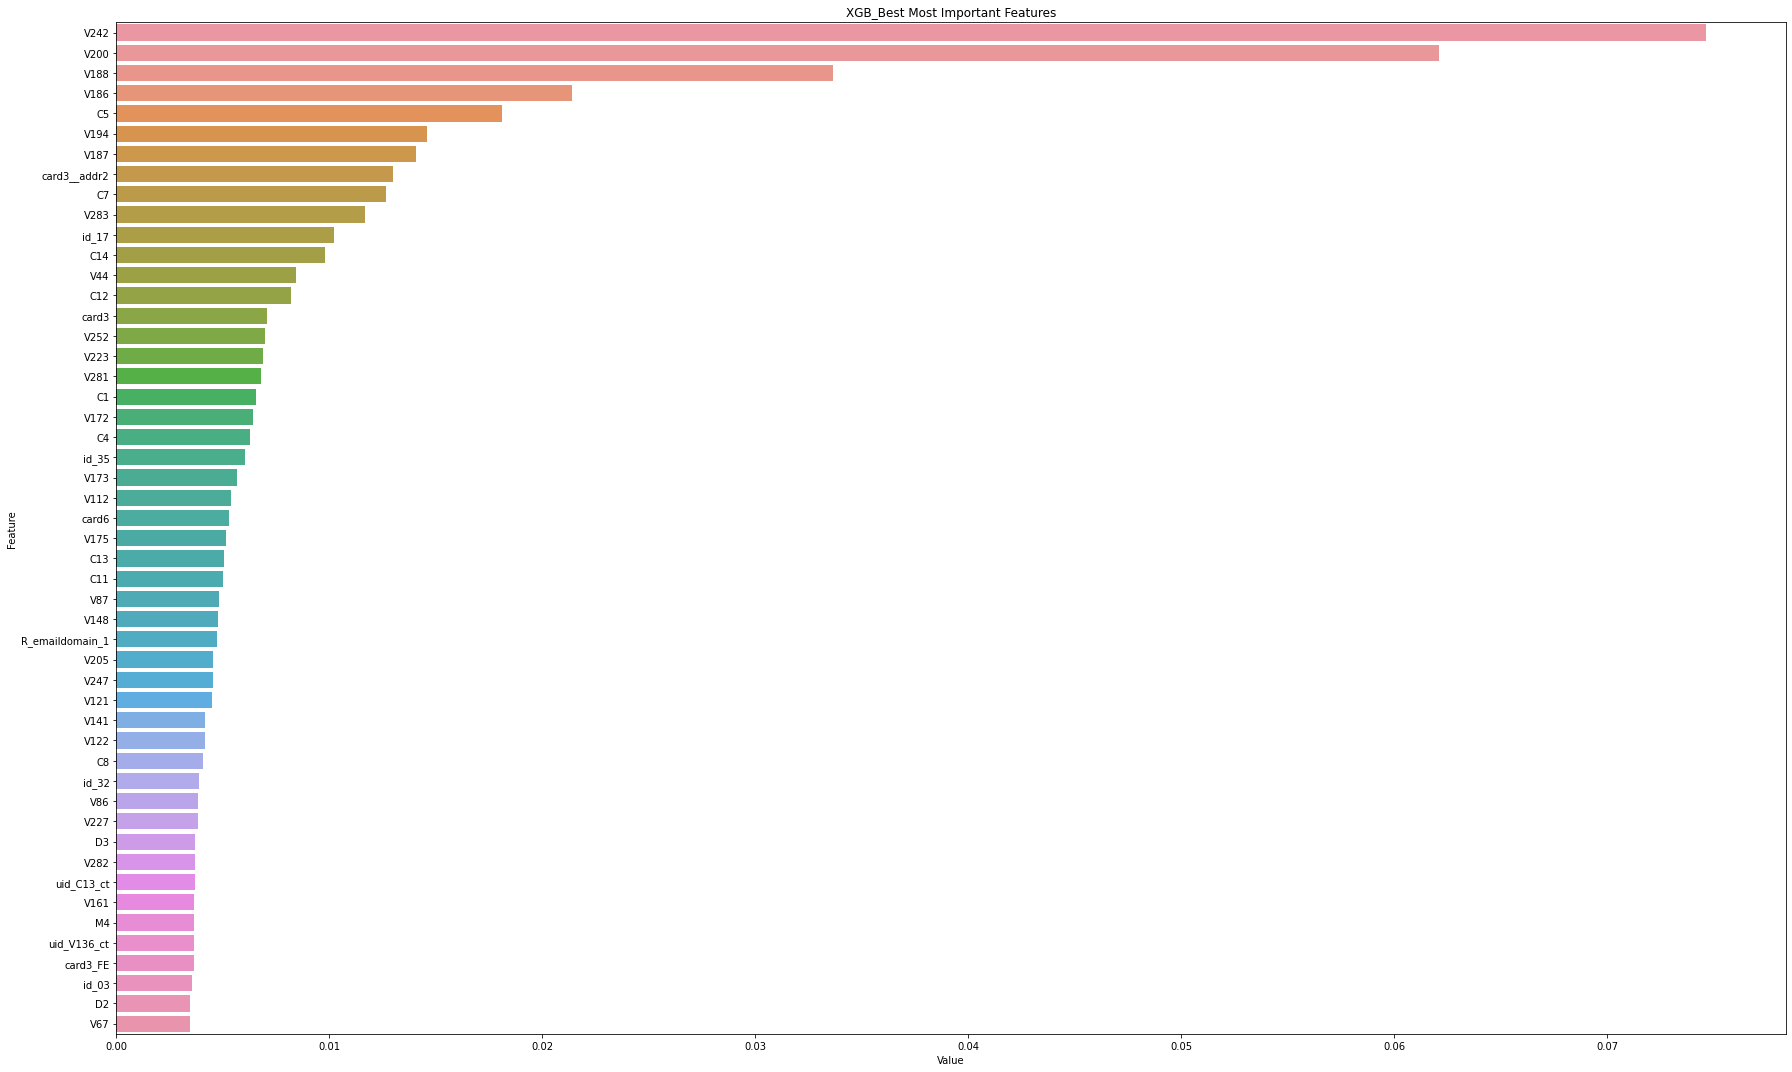

In [28]:
feature_imp = pd.DataFrame(sorted(zip(model_xgb_2000.feature_importances_,X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(25, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB_Best Most Important Features')
plt.tight_layout()
plt.show()

In [34]:
model = xgb.XGBClassifier(colsample_bytree=0.4, max_depth=12, min_samples_split=3,learning_rate= 0.02,n_estimators=1000, subsample=0.8,n_jobs=-1)
model.fit(X_train, y_train)
y=model.predict_proba(X_train)[:, 1]
fpr_xg_tr, tpr_xg_tr, threshold = metrics.roc_curve(y_train, y)
y_pred = model.predict_proba(X_cv)[:, 1]
fpr_xg, tpr_xg, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_xg = metrics.auc(fpr_xg, tpr_xg)
roc_auc_xg_tr= metrics.auc(fpr_xg_tr, tpr_xg_tr)
print('Training_auc',roc_auc_xg_tr)
print('validation_auc',roc_auc_xg)
y_pred_xgboost_1000=model.predict_proba(df_test)[:, 1]

Training_auc 0.9999912516561558
validation_auc 0.981213410247658


## Light lgbm

In [29]:
lgb_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5,
    "early_stopping_rounds": 100,
    "learning_rate": 0.005,
    "max_bin": 255,
    "max_depth": -1,
    "metric": "auc",
    "n_estimators": 20000,
    "n_jobs": -1,
    "num_leaves": 2**9,
    "objective": "binary",
    "seed": 42,
    "subsample": 0.7,
    "subsample_freq": 1,
    "tree_learner": "serial"
}

In [30]:
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_cv,y_cv)], verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.956922	valid_1's auc: 0.93646
[200]	training's auc: 0.973558	valid_1's auc: 0.949175
[300]	training's auc: 0.984781	valid_1's auc: 0.957937
[400]	training's auc: 0.991868	valid_1's auc: 0.963876
[500]	training's auc: 0.996305	valid_1's auc: 0.968505
[600]	training's auc: 0.998322	valid_1's auc: 0.971298
[700]	training's auc: 0.999208	valid_1's auc: 0.973221
[800]	training's auc: 0.999594	valid_1's auc: 0.974748
[900]	training's auc: 0.999779	valid_1's auc: 0.975866
[1000]	training's auc: 0.99988	valid_1's auc: 0.976768
[1100]	training's auc: 0.999939	valid_1's auc: 0.977504
[1200]	training's auc: 0.999972	valid_1's auc: 0.978115
[1300]	training's auc: 0.999989	valid_1's auc: 0.978516
[1400]	training's auc: 0.999996	valid_1's auc: 0.978848
[1500]	training's auc: 0.999999	valid_1's auc: 0.979081
[1600]	training's auc: 1	valid_1's auc: 0.979341
[1700]	training's auc: 1	valid_1's auc: 0.979474
[1800]	tra

LGBMClassifier(colsample_bytree=0.5, early_stopping_rounds=100,
               learning_rate=0.005, max_bin=255, metric='auc',
               n_estimators=20000, num_leaves=512, objective='binary', seed=42,
               subsample=0.7, subsample_freq=1, tree_learner='serial')

In [31]:
y=model_lgb.predict_proba(X_train)[:, 1]
fpr_lg_tr, tpr_lg_tr, threshold = metrics.roc_curve(y_train, y)
y_pred = model_lgb.predict_proba(X_cv)[:, 1]
fpr_lg, tpr_lg, threshold = metrics.roc_curve(y_cv, y_pred)
roc_auc_lg = metrics.auc(fpr_lg, tpr_lg)
roc_auc_lg_tr= metrics.auc(fpr_lg_tr, tpr_lg_tr)
y_pred_lgb=model_lgb.predict_proba(df_test)[:, 1]


## Plot AUC-ROC curve

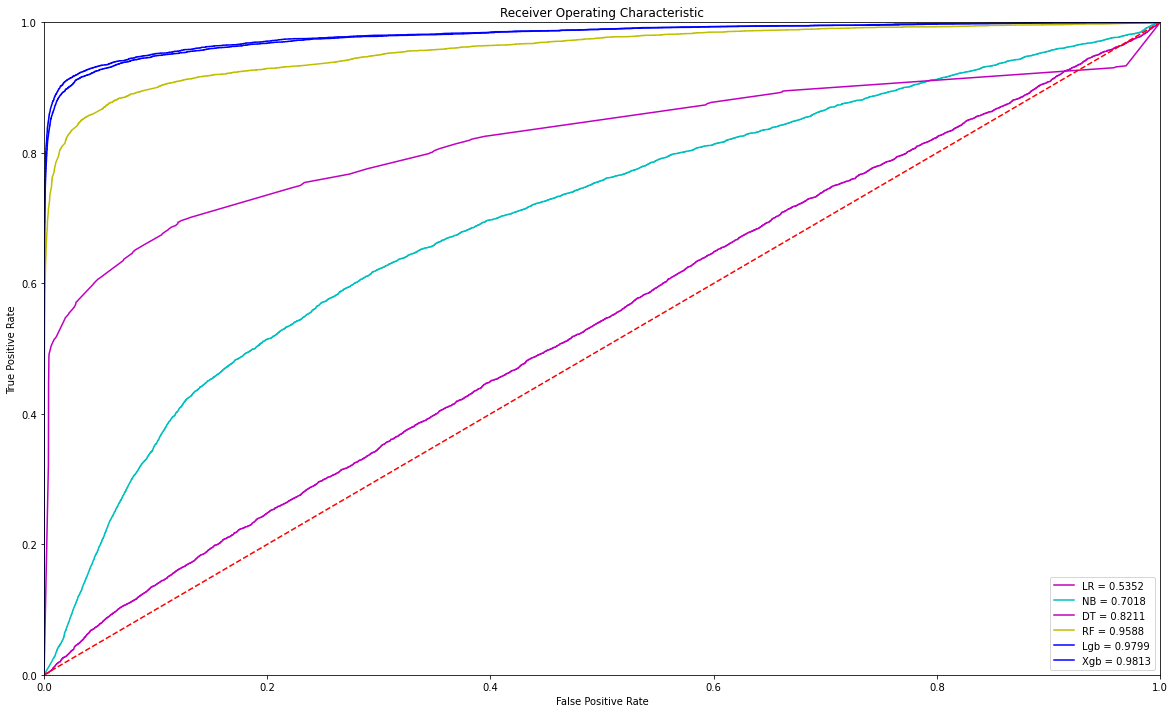

In [33]:
plt.figure(figsize=(20,12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'm', label = 'LR = %0.4f' % roc_auc_LR)
plt.plot(fpr_nb, tpr_nb, 'c', label = 'NB = %0.4f' % roc_auc_NB)
plt.plot(fpr_dt, tpr_dt, 'm', label = 'DT = %0.4f' % roc_auc_DT)
plt.plot(fpr_rf, tpr_rf, 'y', label = 'RF = %0.4f' % roc_auc_RF)
plt.plot(fpr_lg, tpr_lg, 'b', label = 'Lgb = %0.4f' % roc_auc_lg)
plt.plot(fpr_xg, tpr_xg, 'b', label = 'Xgb = %0.4f' % roc_auc_xg)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Voting Classifier

In [13]:
clf1 = RandomForestClassifier(n_estimators=50, random_state=1)
clf2 = XGBClassifier()
clf3 = LGBMClassifier()

eclf1 = VotingClassifier(estimators=[('rf', clf1), ('xgb', clf2), ('lgb', clf3)], voting='soft')
eclf1 = eclf1.fit(X, y)

In [18]:
y_pred_voting=eclf1.predict_proba(df_test)[:,1]

## Kaggle submission results

In [20]:
submission_xgboost=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':y_pred_xgboost_2000})
submission_xgboost.to_csv('submission_xgboost_2000.csv',index=False)

submission_xgboost=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':y_pred_xgboost_1000})
submission_xgboost.to_csv('submission_xgboost_1000.csv',index=False)

submission_xgboost=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':y_pred_lgb})
submission_xgboost.to_csv('submission_lgb.csv',index=False)

submission_xgboost=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':y_pred_voting})
submission_xgboost.to_csv('submission_voting.csv',index=False)


## Ensemble_predictions

In [36]:
def ensemble_predictions(preds):
    ensemble_prediction = np.zeros(preds[0].shape)
    for pred in preds:
        ensemble_prediction += pred
    ensemble_prediction /= len(preds)
    return ensemble_prediction

In [37]:
ensemble_xgb2000_xgb1000 =ensemble_predictions([y_pred_xgboost_2000,y_pred_xgboost_1000])
ensemble_xgb2000_lgb =ensemble_predictions([y_pred_xgboost_2000,y_pred_lgb])
ensemble_xgb1000_lgb =ensemble_predictions([y_pred_xgboost_1000,y_pred_lgb])
ensemble_all=ensemble_predictions([y_pred_xgboost_2000,y_pred_xgboost_1000,y_pred_lgb])

In [38]:
submission_ensemble=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':ensemble_xgb2000_xgb1000})
submission_ensemble.to_csv('submission_ensemble_xgb2000_xgb1000.csv',index=False)

submission_ensemble=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':ensemble_xgb2000_lgb})
submission_ensemble.to_csv('submission_ensemble__xgb2000_lgb .csv',index=False)

submission_ensemble=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':ensemble_xgb1000_lgb})
submission_ensemble.to_csv('submission_ensemble_xgb1000_lgb.csv',index=False)

submission_ensemble=pd.DataFrame({'TransactionID':df_trans['TransactionID'].values, 'isFraud':ensemble_all})
submission_ensemble.to_csv('submission_ensemble_all.csv',index=False)



In [26]:
from prettytable import PrettyTable
x = PrettyTable()

In [22]:
x.field_names = ["Model_name", "Parameters", "Train_AUC", "Val_AUC",]
x.add_rows(
    [   ["lgbm", 20000, 0.9999, 0.9798],
        ["XG_Boost_2000", 2000, 0.9999, 0.9813],
        ["XG_Boost_1000", 1000, 0.9948, 0.9812],
    ]
)
print(x)

+---------------+------------+-----------+---------+
|   Model_name  | Parameters | Train_AUC | Val_AUC |
+---------------+------------+-----------+---------+
|      lgbm     |   20000    |   0.9999  |  0.9798 |
| XG_Boost_2000 |    2000    |   0.9999  |  0.9813 |
| XG_Boost_1000 |    1000    |   0.9948  |  0.9812 |
+---------------+------------+-----------+---------+


In [27]:
x.field_names = ["Model_name","Kaggle_public_score","LBposition"]
x.add_rows(
    [   
        ["Ensemble__xgb2000_lgb",0.9511, '1790/6380'],
        ["Ensemble_all",0.9503, '1800/6380'],
        ["Ensemble__xgb1000_lgb",0.9498, '1820/6380'],
        ["Ensemble__xgb2000_xgb1000",0.9492, '1832/6380'],
        ["XG_Boost_2000",0.9489, '1970/6380'],
        ["Lgb",0.9487,'2021/6380'],
        ["XG_Boost_1000",0.9484,'2050/6380'  ],
        ["Voting_classifier",0.9287,'4550/6380'  ],
        
    ]
)
print(x)

+---------------------------+---------------------+------------+
|         Model_name        | Kaggle_public_score | LBposition |
+---------------------------+---------------------+------------+
|   Ensemble__xgb2000_lgb   |        0.9511       | 1790/6380  |
|        Ensemble_all       |        0.9503       | 1800/6380  |
|   Ensemble__xgb1000_lgb   |        0.9498       | 1820/6380  |
| Ensemble__xgb2000_xgb1000 |        0.9492       | 1832/6380  |
|       XG_Boost_2000       |        0.9489       | 1970/6380  |
|            Lgb            |        0.9487       | 2021/6380  |
|       XG_Boost_1000       |        0.9484       | 2050/6380  |
|     Voting_classifier     |        0.9287       | 4550/6380  |
+---------------------------+---------------------+------------+
